# Figure S2: Quantitative assessment of the inter-run duration model

## import and setup

In [1]:
import fnmatch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import glob

from sessionlists import (dist60, dist90, dist120, TM20, TM10, TM2, TMrev2, TMrev10, TMrev20)
from utils import *
from plotting import *
from model_functions import *

plt.style.use('./Figures/paper.mplstyle')

In [2]:
# Define folder with data
root = "/home/thomas/Desktop/ALLDATA"

print("Path to data is: %s"%root)
print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

Path to data is: /home/thomas/Desktop/ALLDATA
Found 34 rats in the data folder


In [3]:
rat_markers = {}
intact = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 
            'RatM53', 'RatM54']

m, f = 0, 0
male_palette = create_teal_palette(num_shades=len([x for x in intact if 'M' in x]))
female_palette = create_blue_violet_palette(num_shades=len([x for x in intact if 'F' in x]), start_intensity=80)

for index, animal in enumerate(intact):
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[female_palette[f], 'o', '-']
        f += 1
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[male_palette[m], 'o', '-']
        m += 1
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

# S2A Block-by-block median inter-run durations at 120 cm
# S2B Block-by-block median inter-run error

Median error: 0.61s
[[0.04101926 0.14080515 0.03432562 0.22338064 0.07117698 0.17623993
  0.03697412 0.23047947 0.27450676 0.60265542 0.36221186 1.03646563]
 [0.04438888 0.23472432 0.01561505 0.13866112 0.09445853 0.21476141
  0.16800224 0.31946019 0.07107956 1.17771351 0.24733266 0.68856256]]
Median error: 0.50s


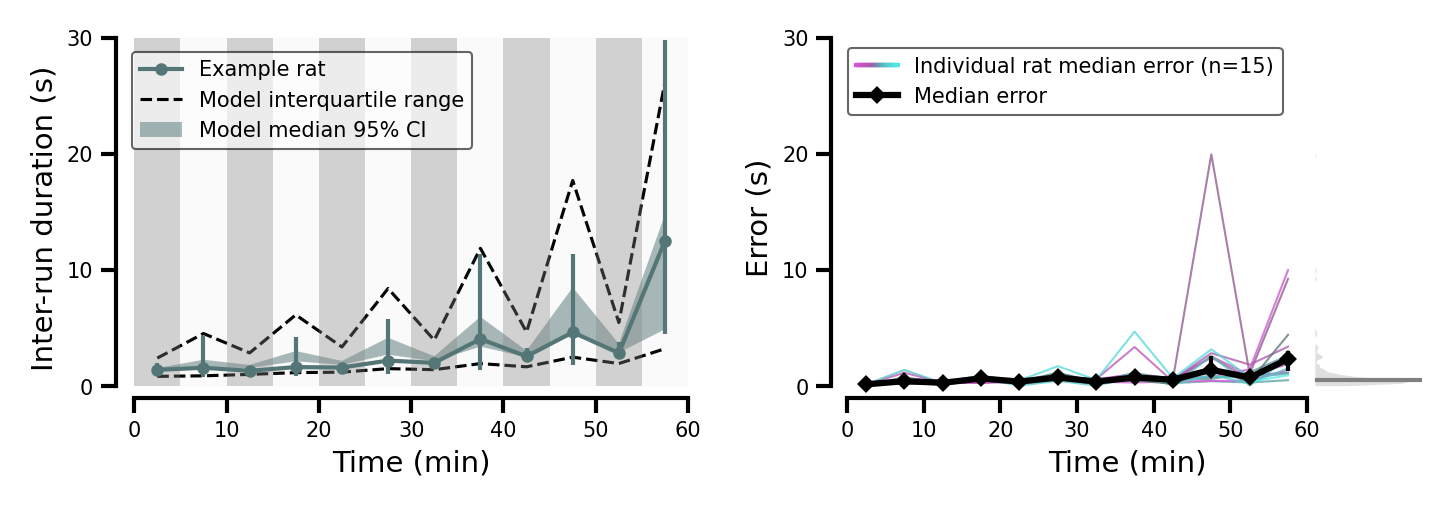

In [4]:

def FigureS1A(root, ax=None, n_simul=10000):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]
    
    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Inter-run duration (s)")
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 30)
    ax.set_yticks([0, 10, 20, 30])
    space_axes(ax)


    # experimental rat data
    animal='RatM00'
    session='RatM00_2021_07_22_16_13_03'

    _params = get_from_pickle(root, animal, session, name="params.p")
    blocks = _params['blocks']
    rewardProbaBlock = _params['rewardProbaBlock']


    sessions = matchsession(animal, dist120)
    data = [[],[],[],[],[],[],[],[],[],[],[],[]]
    for i, session in enumerate(sessions):
        example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeinZone.p")
        for j in range(0, 12):
            data[j] = np.append(data[j], example_runningTimeInLeftBin[j]+example_runningTimeInRightBin[j])

    data_medians = [np.median(data[i]) for i in range(12)]
    data_bot_percentiles = [np.percentile(data[i], 25) for i in range(12)]
    data_top_percentiles = [np.percentile(data[i], 75) for i in range(12)]
        
    ax.errorbar([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
                data_medians,
                yerr=[[data_medians[i]-data_bot_percentiles[i] for i in range(12)], [data_top_percentiles[i]-data_medians[i] for i in range(12)]],
                marker='o', ms=2, color=rat_markers[animal][0], zorder=4, alpha=1)
    
    ax.plot([-100, -101], [-100, -101], marker='o', ms=2, 
            color=rat_markers[animal][0], zorder=4, alpha=1, label='Example rat')
   


    # fit, generate samples from distribution with fit parameters, take median
    N_bins = 6
    N_avg = 4

    ex_alpha, ex_alpha_t, ex_alpha_u, ex_gamma, ex_gamma_t, ex_gamma_u, _, _, _, _, _, _ = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))
    ex_alpha = ex_alpha[animal]['120']
    ex_alpha_t = ex_alpha_t[animal]['120']
    ex_alpha_u = ex_alpha_u[animal]['120']
    ex_gamma = ex_gamma[animal]['120']
    ex_gamma_t = ex_gamma_t[animal]['120']
    ex_gamma_u = ex_gamma_u[animal]['120']


    ALPHA = np.zeros((N_bins, N_avg))
    GAMMA = np.zeros((N_bins, N_avg))
    for bin in range(N_bins):
        for avg in range(N_avg):
            ALPHA[bin, avg] = ex_alpha + bin*ex_alpha_t + avg*ex_alpha_u
            GAMMA[bin, avg] = ex_gamma + bin*ex_gamma_t + avg*ex_gamma_u

    a = []
    g = []
    for i in range(6):
        a.append(.9*ALPHA[i][0]+0.1*ALPHA[i][1])
        a.append(.9*ALPHA[i][-1]+0.1*ALPHA[i][-2])
        g.append(.9*GAMMA[i][0]+0.1*GAMMA[i][1])
        g.append(.9*GAMMA[i][-1]+0.1*GAMMA[i][-2])


    if os.path.exists("picklejar/exampleRatErrorInterRunDuration.p"):
        error, simuls_med, simuls_bot, simuls_top = pickle.load(open("picklejar/exampleRatErrorInterRunDuration.p", "rb"))
    else:
        error = np.zeros((n_simul, 12))
        simuls_med = np.zeros((n_simul, 12))
        simuls_bot = np.zeros((n_simul, 12))
        simuls_top = np.zeros((n_simul, 12))
        for _ in range(n_simul):
            if _ / 1000 == 0:
                print(f'{_}/{n_simul}')
            res = [generate_idle_time(a[i], g[i], len(data[i]), seed=_) for i in range(len(blocks))]

            simuls_med[_] = [np.median(res[i]) for i in range(0, len(blocks))]
            simuls_bot[_] = [np.percentile(res[i], 25) for i in range(0, len(blocks))]
            simuls_top[_] = [np.percentile(res[i], 75) for i in range(0, len(blocks))]
            error[_] = [np.sqrt((np.median(data[i]) - np.median(res[i]))**2) for i in range(0, len(blocks))]
        pickle.dump((error, simuls_med, simuls_bot, simuls_top), open("picklejar/exampleRatErrorInterRunDuration.p", "wb"))

    CI = np.percentile(simuls_med[:, :], [2.5, 97.5], axis=0)
    y = np.concatenate([CI[0], CI[1][::-1]])
    x = np.concatenate([[(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                        [(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))][::-1]])
    ax.fill(x, y, alpha=.5, color=rat_markers[animal][0], label='Model median 95% CI', zorder=0, lw=0)

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
            np.median(simuls_bot, axis=0), color='k', ls='--', lw=.75,
            zorder=0, alpha=1, label='Model interquartile range')
    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
            np.median(simuls_top, axis=0), color='k', ls='--', lw=.75,
            zorder=0, alpha=1)#, label='Inter-run duration $3^{rd}$ quartile')

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 0.99),
              frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

def FigureS1B(error, animalList, ax=None, n_simul=10000):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    
    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
            [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
            [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]
    
    median_error_per_block = {}
    for animal in intact:

        # error between median data and simulation
        zorder = 1 if animal == 'RatM00' else 0
        _alpha = .5 if animal == 'RatM00' else .1

        median_error_per_block[animal] = np.median(error[animal], axis=0)
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
                [median_error_per_block[animal][i] for i in range(0, len(blocks))],
                color=rat_markers[animal][0], ls='-', zorder=zorder+1, lw=0.5, alpha=.75)
        
        ax.plot([-200], [-100], color='silver', lw=.5, label='Individual rat median error (n=15)')

        #  error for each of the 10000 simuls to make CI
        CI = np.percentile(error[animal][:, :], [2.5, 97.5], axis=0)
        y = np.concatenate([CI[0], CI[1][::-1]])
        x = np.concatenate([[(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                            [(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))][::-1]])

    # group median and 25/75 percentiles
    median_of_median = [np.median([median_error_per_block[animal][i] for animal in intact]) for i in range(len(blocks))]
    print(f'Median error: {np.median(median_of_median):.2f}s')

    bot, top = 25, 75
    err = []
    for i in range(12):
        percentile_bot = np.percentile([median_error_per_block[animal][i] for animal in animalList], bot)
        percentile_top = np.percentile([median_error_per_block[animal][i] for animal in animalList], top)
        err.append([median_of_median[i] - percentile_bot, percentile_top - median_of_median[i]])
    err = np.array(err).T
    print(err)

    ax.errorbar([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], median_of_median, yerr=err, 
                    capsize=0, color='k', marker='D', markersize=2, linestyle='-', lw=1.5, elinewidth=1, zorder=2)

    median = ax.plot([-100, -101], [-100, -101], color='k', marker='D', markersize=2, linestyle='-', lw=1.5,
                    label=f'Median error', zorder=2)
   

    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Error (s)")
    ax.set_xlim(0, 60)
    ax.set_xticks([0, 10, 20, 30, 40, 50, 60])
    ax.set_ylim(0, 30)
    ax.set_yticks([0, 10, 20, 30])
    space_axes(ax, x_ratio_right=.25)

    pooled_error = np.zeros((n_simul * len(intact), 12))
    for i, animal in enumerate(intact):
        pooled_error[i*n_simul:(i+1)*n_simul, :] = median_error_per_block[animal]
    
    all_pooled = pooled_error.flatten()
    ax.axhline(y=np.median(all_pooled), xmin=.822, xmax=1, color='gray')
    print(f'Median error: {np.median(all_pooled):.2f}s')

    

    violin_parts = ax.violinplot(all_pooled, positions=[61], showextrema=False, widths=25)
    for pc in violin_parts['bodies']:
        verts = pc.get_paths()[0].vertices
        verts[:, 0] = np.where(verts[:, 0] < 61, 61, verts[:, 0])  
        pc.set_facecolor('gray')
        pc.set_edgecolor('gray')
        pc.set_alpha(0.25)
        pc.set_linewidth(0)

    add_colored_intact(ax, handles=[median],
                    labels=['Median error'], text=f'Individual rat median error (n={len(animalList)})', 
                    loc='upper left', bbox=(.01, 1))


n_simul = 10000
fig, axs = plt.subplots(1, 2, figsize=(cm2inch(12), cm2inch(4)))
FigureS1A(root=root, ax=axs[0], n_simul=n_simul)

if os.path.exists("picklejar/modelErrorInterRunDuration10000.p"):
    error_idle = pickle.load(open("picklejar/modelErrorInterRunDuration10000.p", "rb"))
else:
    error_idle = process_error_idle_time(animalList=intact, sessionList=dist120, n_simul=n_simul)  # 530 minutes for 10000 simulations * 28 rats
    pickle.dump(error_idle, open("picklejar/modelErrorInterRunDuration10000.p", "wb"))

FigureS1B(error_idle, animalList=intact, ax=axs[1], n_simul=n_simul)

# S2C Total loss of the model depending on trial history length

3.4747474747474745


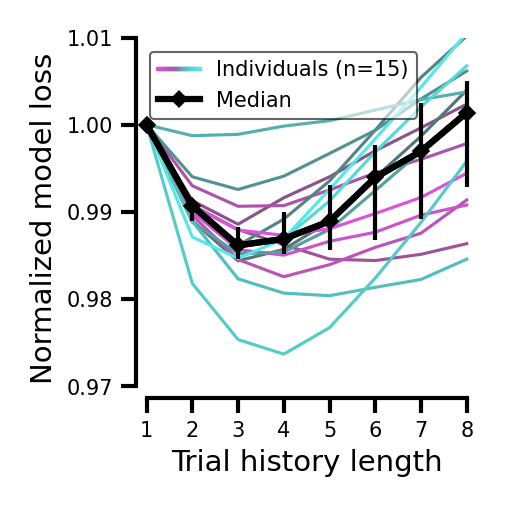

In [5]:
def FigureS2C(animalList, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))

    memsizes = np.arange(1, 9)
    history_losses = pickle.load(open("picklejar/rewardHistoryLossInterRunDuration.p", "rb"))
    normalized_history_losses = {animal: (history_losses[animal])/(history_losses[animal][0]) for animal in intact}
    median_losses = np.median(np.array(list(normalized_history_losses.values())), axis=0)
    top_percentile_losses = np.percentile(np.array(list(normalized_history_losses.values())), 75, axis=0)
    bot_percentile_losses = np.percentile(np.array(list(normalized_history_losses.values())), 25, axis=0)

    for animal in intact:
        ax.plot(memsizes, normalized_history_losses[animal], color=rat_markers[animal][0], lw=.75)

    median = ax.plot(memsizes, median_losses, color='k', marker='D', markersize=2, linestyle='-', lw=1.5, label='Median')


    add_colored_intact(ax, handles=[median],
                    labels=['Median'], text=f'Individuals (n={len(animalList)})', 
                    loc='upper left', bbox=(.01, .99))

    ax.errorbar(memsizes, median_losses,
                yerr=[[median_losses[i]-bot_percentile_losses[i] for i in range(len(memsizes))], [top_percentile_losses[i]-median_losses[i] for i in range(len(memsizes))]],
                    capsize=0, color='k', marker='D', markersize=2, linestyle='-', lw=1.5, elinewidth=1, zorder=100)


    z = np.poly1d(np.polyfit(memsizes, median_losses, 3))
    x=np.linspace(1, 8, 100)
    print(x[np.argmin(z(x))])

    ax.set_xlabel('Trial history length')
    ax.set_xlim(1, 8)
    ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8])

    ax.set_ylabel('Normalized model loss')
    ax.set_ylim(0.97, 1.01)
    ax.set_yticks([.97, .98, .99, 1.0, 1.01])
    space_axes(ax)

FigureS2C(animalList=intact, ax=None)

# Figure S2D  Model BIC score following parameter ablation

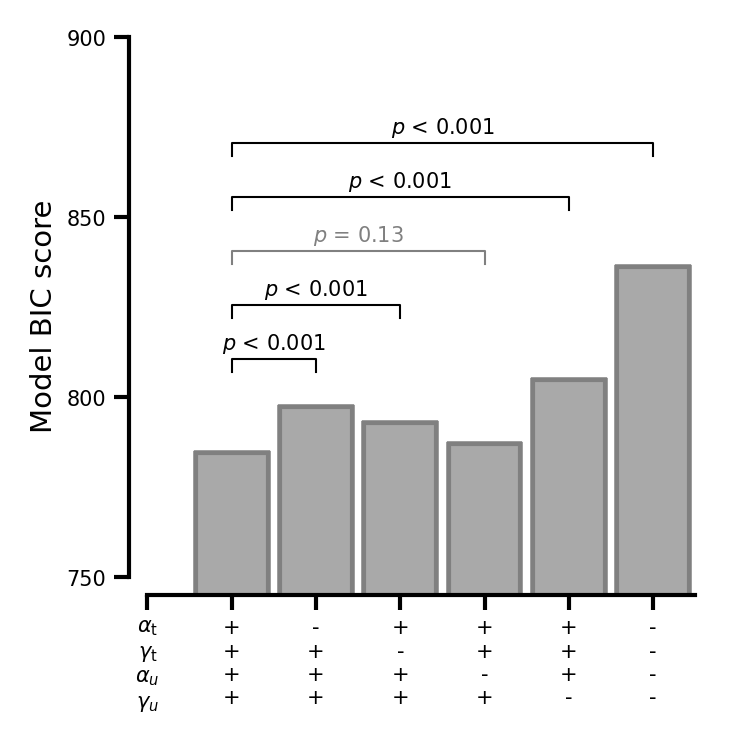

In [6]:

def FigureS2D(animalList, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(cm2inch(6), cm2inch(6)))

    the_keys_i_want = [(False, False, False, False), 
                    (True, False, False, False), 
                    (False, True, False, False), 
                    (False, False, True, False), 
                    (False, False, False, True), 
                    (True, True, True, True)]

    ablation_losses = pickle.load(open("picklejar/ablationLossesInterRunDuration.p", "rb"))
    for animal in animalList:
        for i, key in enumerate(the_keys_i_want):
            ax.bar(i+1, -np.sum([ablation_losses[animal][key] for animal in intact]), 
                   color='gray', width=.85, facecolor='darkgray', edgecolor='gray', lw=1, zorder=1)

        ax.set_ylabel('Model BIC score')
        ax.set_xticks(np.arange(7))
        ax.set_xticklabels(dict_to_xticklabels({k:ablation_losses[animal][k] for k in the_keys_i_want}, 
                                               labels=['$\\alpha_{\mathrm{t}}$', '$\\gamma_{\mathrm{t}}$', '$\\alpha_u$', '$\\gamma_u$']))
        ax.set_ylim(750, 900)
        ax.set_yticks([750, 800, 850, 900])
        ax.set_xlim(0, 6.5)
        ax.axhline(1, color='k', linestyle='--')

    LLratio_vs_complete(ablation_losses, the_keys_i_want, animalList, ax)
    space_axes(ax)

FigureS2D(animalList=intact, ax=None)

# Figure S2: Quantitative assessment of the inter-run duration model.

Median error: 0.61s
[[0.04101926 0.14080515 0.03432562 0.22338064 0.07117698 0.17623993
  0.03697412 0.23047947 0.27450676 0.60265542 0.36221186 1.03646563]
 [0.04438888 0.23472432 0.01561505 0.13866112 0.09445853 0.21476141
  0.16800224 0.31946019 0.07107956 1.17771351 0.24733266 0.68856256]]
Median error: 0.50s
3.4747474747474745


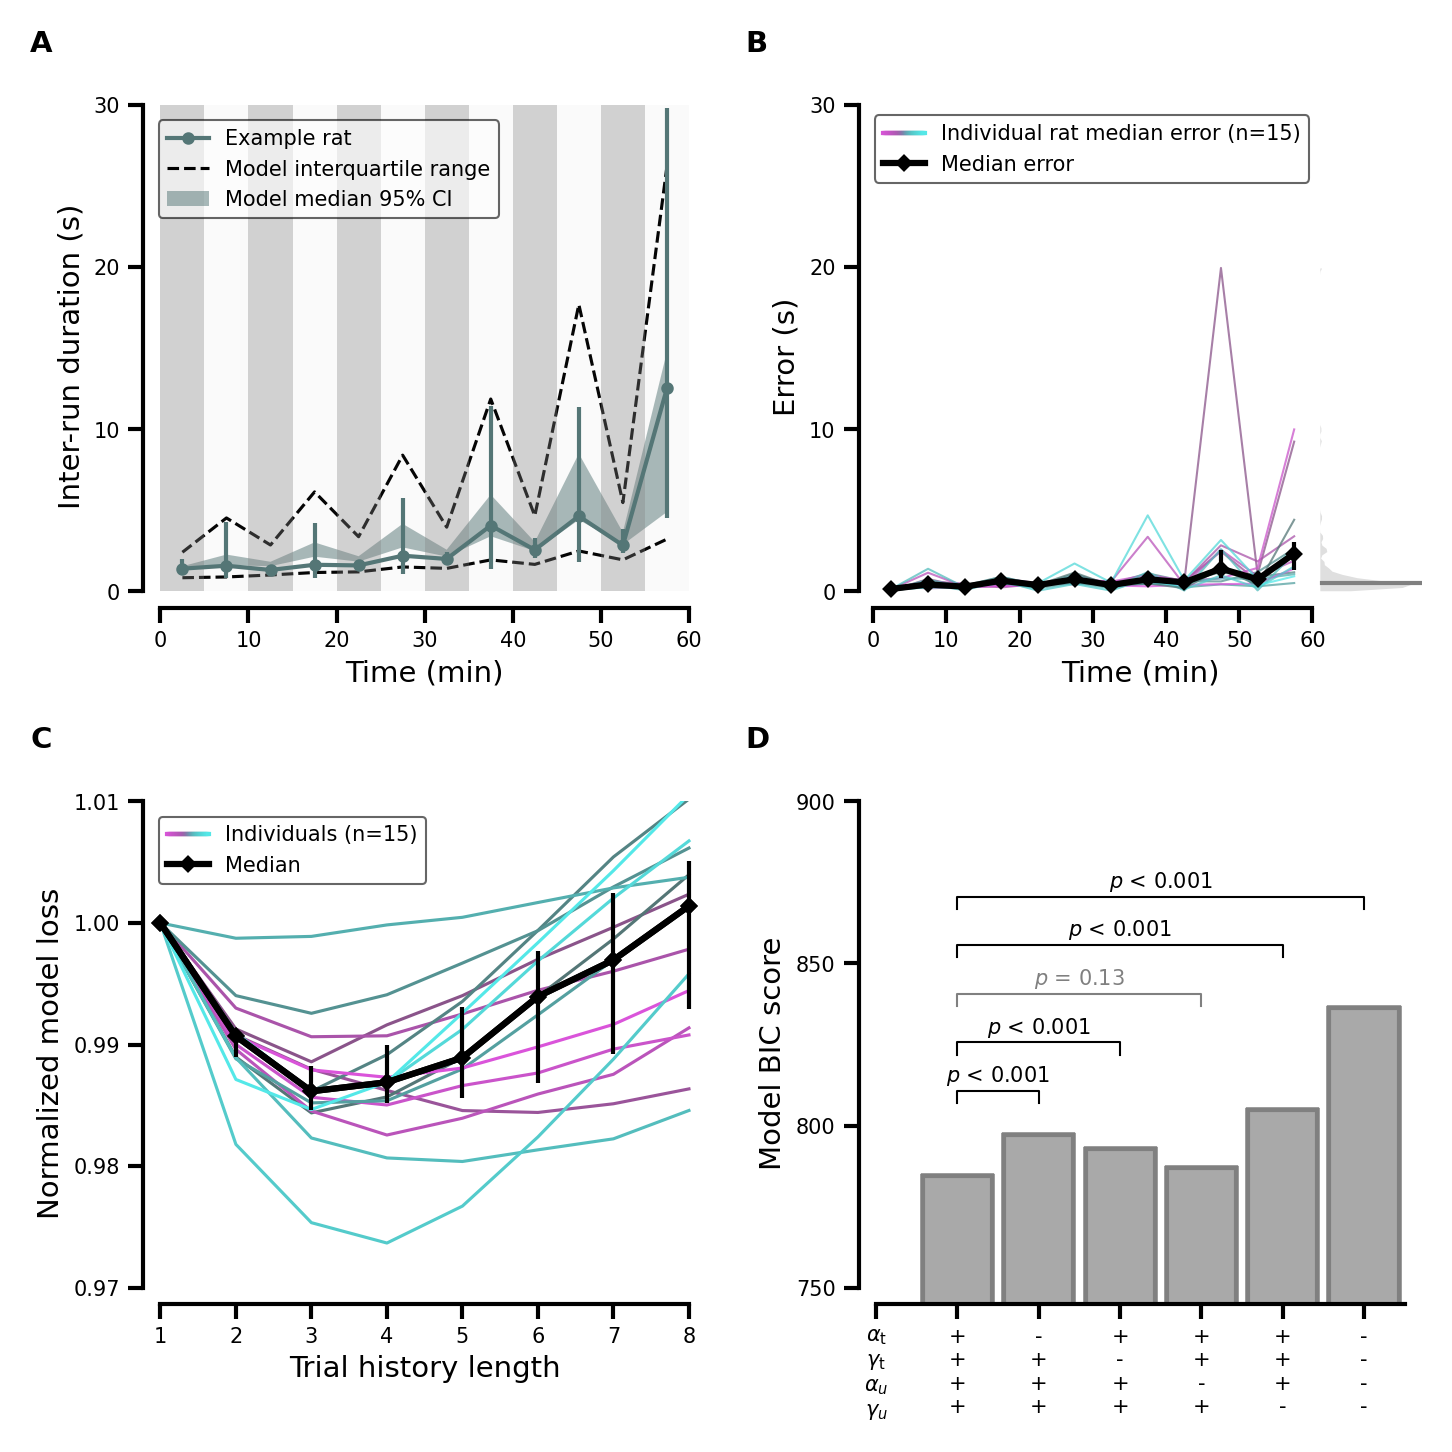

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(cm2inch(12), cm2inch(12)))

FigureS1A(root=root, ax=axs[0, 0])
FigureS1B(error_idle, animalList=intact, ax=axs[0, 1])
FigureS2C(animalList=intact, ax=axs[1, 0])
FigureS2D(animalList=intact, ax=axs[1, 1])

for ax, letter in zip(axs.flatten(), ["A", "B", "C", "D"]):
    old_letter_on_subplot(ax, letter, x_rel=-0.2, y_rel=1.15)

plt.savefig("./Figures_paper/Figure_S2.pdf", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

plt.savefig("./Figures_paper/Figure_S2.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)